In [1]:
# Import libraries

# System libraries 
import os
import time
import calendar
import datetime

# Math libraries to process the data 
import numpy as np 
import pandas as pd

# Library for predictive data analysis
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from yellowbrick.cluster import intercluster_distance
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import rand_score

# Graph libraries to produce graphs 
import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
import seaborn as sns 
import plotly.express as px


In [2]:
dataframe = pd.read_csv(
    "data/dataframe.csv",
)

# Set customer_unique_id as index
dataframe.set_index("customer_unique_id", inplace=True)

# Convert columns to datetime type
dataframe['order_delivered_carrier_date'] = pd.to_datetime(dataframe['order_delivered_carrier_date'])
dataframe['order_delivered_customer_date'] = pd.to_datetime(dataframe['order_delivered_customer_date'])
dataframe['order_purchase_timestamp'] = pd.to_datetime(dataframe['order_purchase_timestamp'])
dataframe['order_estimated_delivery_date'] = pd.to_datetime(dataframe['order_estimated_delivery_date'])
dataframe['review_creation_date'] = pd.to_datetime(dataframe['order_purchase_timestamp'])
dataframe['shipping_limit_date'] = pd.to_datetime(dataframe['shipping_limit_date'])

# Create columns day, month and year for datetime column
for column in dataframe.select_dtypes('datetime64[ns]'):
    dataframe[column + '_year'] = dataframe[column].dt.year
    dataframe[column + '_month'] = dataframe[column].dt.month
    dataframe[column + '_day'] = dataframe[column].dt.day
    
# Drop datetime columns
dataframe = dataframe.drop([
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_purchase_timestamp',
    'order_estimated_delivery_date',
    'review_creation_date',
    'shipping_limit_date'
], axis=1)

# Olist : segmenter des clients d'un site e-commerce (suite)

## Sommaire

* [IV. Modélisation](#IV)
    * [1. Réduction de dimensions](#IV1)
    * [2. K-Means](#IV2)
        * [a. K-Means sur l'ensemble des données](#IV2a)
        * [b. K-Means sur les données réduites](#IV2b)
        * [c. K-Means sur les features RFM](#IV2c)
        * [d. Stabilité du clustering](#IV2d)
    * [3. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)](#IV3)
    * [4. Clustering agglomératif](#IV4)
    * [5. Maintenance de la solution](#IV5)
    
## IV. Modélisation<a class="anchor" id="IV"></a>

### 1. Réduction de dimensions<a class="anchor" id="IV1"></a>

Nous allons effectuer une réduction de dimensions afin de faciliter la visualisation de nos données en les ramenant dans un espace réduit. De plus, ceci va aussi nous permettre de diminuer le temps de calcul des algorithmes de clustering.

In [15]:
# Let's choose 3 new components
num_components = 10

# Let's instantiate our PCA proccessor
pca = PCA(n_components=num_components)
dataframe_reduced = pca.fit_transform(dataframe)

print(f'Number of components to keep over at least 95% of variance: {np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)}')

Number of components to keep over at least 95% of variance: 7


Nous avons donc besoin de **7** composantes principales pour garder au moins 95% de la variance.

In [3]:
# Let's instantiate our PCA proccessor
pca = PCA(n_components=7)
dataframe_reduced = pca.fit_transform(dataframe)

### 2. K-Means<a class="anchor" id="IV2"></a>

Maintenant que nous avons notre dataframe de données réduites, on va pouvoir passer à la modélisation. On va utiliser un algorithme K-Means qui se base sur des calculs de distance entre les points de notre jeu de données et un point nommé centroïde. Il est possible d'entrer les coordonnées de ce centroïde. Dans notre situation, on ne possède pas de contrainte sur le placement de ces centroïdes, on va donc laisser ce paramètre s'initialiser aléatoirement. En revanche, on va chercher à déterminer le nombre de clusters (le K du K-Means). Pour cela, on utilise la "méthode du coude" (**Elbow Method**) qui détecte une zone de "coude" dans la minimisation du coût.

#### a. K-Means sur l'ensemble des données<a class="anchor" id="IV2a"></a>

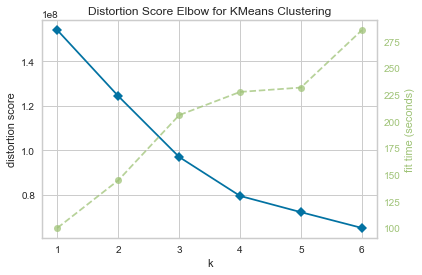

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [96]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,7), locate_elbow=False)

# Fit the data to the visualizer
visualizer.fit(dataframe)
visualizer.poof()

La zone de coude n'est pas clairement visible. Nous allons donc comparer les coefficients de Silhouette pour 3, 4 et 5 clusters.

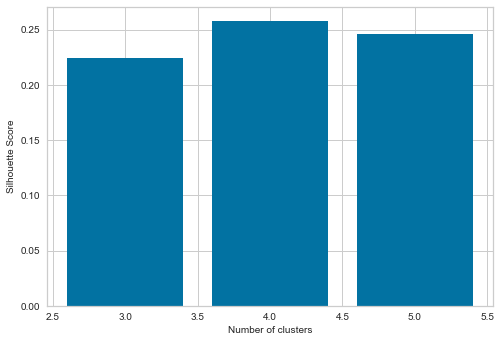

In [18]:
silhouette_scores = [] 
n_clusters = [3, 4, 5]

for n_cluster in n_clusters:
    silhouette_scores.append( 
        silhouette_score(
            dataframe, 
            KMeans(n_clusters=n_cluster).fit_predict(dataframe)
        )
    ) 

# Plotting a bar graph to compare the results 
k = [3, 4, 5]
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize=10) 
plt.ylabel('Silhouette Score', fontsize=10) 
plt.show()

Le nombre de cluster idéal est de **4**. On va donc entraîner notre modèle avec ce paramètre.

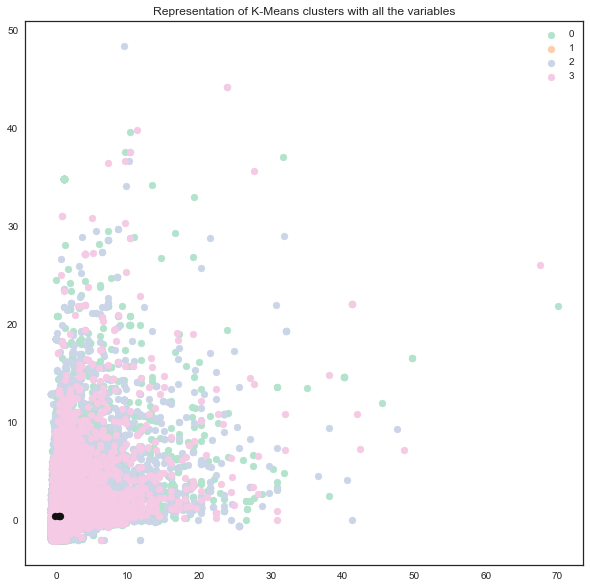

In [4]:
sns.set_palette("Pastel2")
sns.set_style("ticks")

# Create a k-means clustering model
model = KMeans(n_clusters=4, random_state=42)

# Prediction
label = model.fit_predict(dataframe)
u_labels = np.unique(label)
centroids = model.cluster_centers_

array = dataframe.to_numpy()

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(array[label==i, 0], array[label==i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:,1], c='k')
plt.legend()
plt.title('Representation of K-Means clusters with all the variables')
plt.show()

Pour évaluer l'efficacité de notre modèle, nous allons utiliser 2 métriques : le coefficient de silhouette et l'indice de Davies-Bouldin. Le premier permet d'évaluer si ce point appartient au « bon » cluster tandis que le second permet de comparer les distances intra-clusters (l'homogénéité, c'est-à-dire la moyenne des distances de chacun des points contenus dans le cluster au centroïde), que l'on veut faibles, aux distances inter-clusters (la séparation, soit la distance entre leurs centroïdes), que l'on veut grandes. 

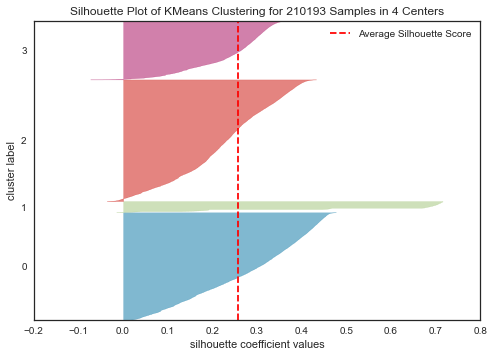

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 210193 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [5]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(dataframe)
visualizer.show()

In [6]:
print("Silhouette score:", silhouette_score(dataframe, label))
print("Davies-Bouldin score:", davies_bouldin_score(dataframe, label))

Silhouette score: 0.25766170829969215
Davies-Bouldin score: 1.3000069822806044


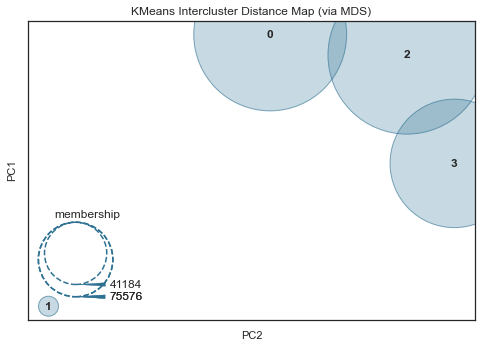

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=4, random_state=42))

In [7]:
intercluster_distance(KMeans(4, random_state=42), dataframe)

Nos clusters ne semblent pas équilibrés, le dernier est bien plus faible que les autres. Les métriques d'évaluation nous indiquent que nos clients sont assez souvent comptés dans le mauvais cluster et qu'ils ne sont pas très homogènes. 

Nous allons maintenant essayer d'appliquer le K-Means sur les données réduites.

#### b. K-Means sur les données réduites<a class="anchor" id="IV2b"></a>

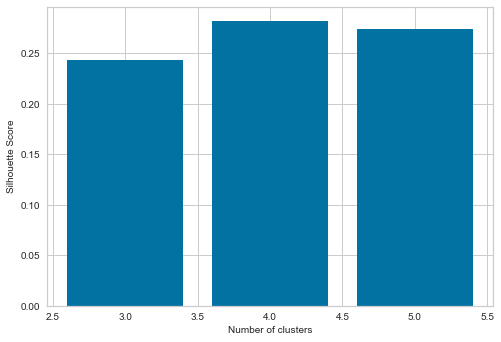

In [21]:
silhouette_scores = [] 
n_clusters = [3, 4, 5]

for n_cluster in n_clusters:
    silhouette_scores.append( 
        silhouette_score(
            dataframe_reduced, 
            KMeans(n_clusters=n_cluster).fit_predict(dataframe_reduced)
        )
    ) 

# Plotting a bar graph to compare the results 
k = [3, 4, 5]
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize=10) 
plt.ylabel('Silhouette Score', fontsize=10) 
plt.show()

Le nombre de cluster idéal avec nos features réduites est toujours de **4**.

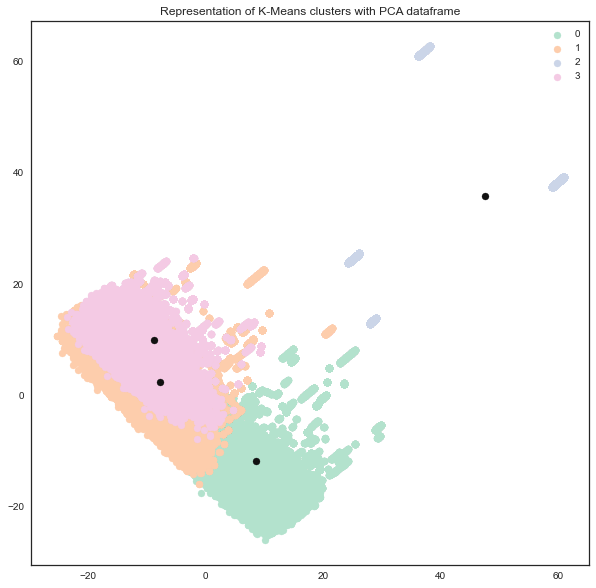

In [8]:
# Create a k-means clustering model
model = KMeans(n_clusters=4, random_state=42)

# Prediction
label = model.fit_predict(dataframe_reduced)
u_labels = np.unique(label)
centroids = model.cluster_centers_

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(dataframe_reduced[label==i, 0], dataframe_reduced[label==i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:,1], c='k')
plt.legend()
plt.title('Representation of K-Means clusters with PCA dataframe')
plt.show()

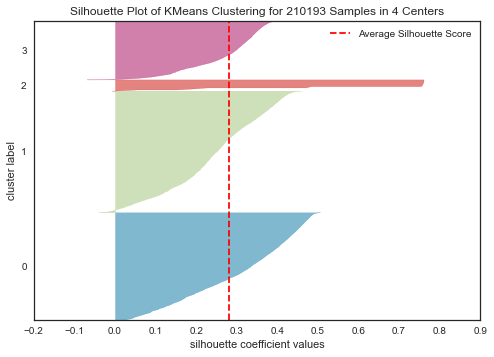

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 210193 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [9]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(dataframe_reduced)
visualizer.show()

In [10]:
print("Silhouette score:", silhouette_score(dataframe_reduced, label))
print("Davies-Bouldin score:", davies_bouldin_score(dataframe_reduced, label))

Silhouette score: 0.28190534223980834
Davies-Bouldin score: 1.2178826762895496


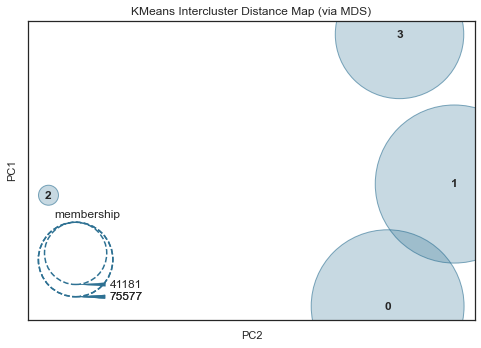

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=4, random_state=42))

In [11]:
intercluster_distance(KMeans(4, random_state=42), dataframe_reduced)

Nos données réduites ont obtenu de meilleures résultats que l'ensemble des données. Nos clusters sont assez bien séparés mais pas équilibrés.

#### c. K-Means sur les features RFM<a class="anchor" id="IV2c"></a>

In [3]:
# Create a dataframe with our RFM features
rfm_dataframe = dataframe[[
    "RFM_score", "R", "F", "M"
]]
rfm_dataframe.describe()

,RFM_score,R,F,M
count,210193.000000,210193.000000,210193.000000,210193.000000
mean,-0.220333,-0.145793,-0.622361,0.211565
std,0.577203,0.377106,0.484798,0.605069
min,-1.250000,-0.666667,-1.000000,-0.500000
25%,-0.750000,-0.333333,-1.000000,-0.500000
50%,-0.250000,0.000000,-1.000000,0.000000
75%,0.250000,0.333333,0.000000,1.000000
max,1.000000,0.333333,0.000000,1.000000


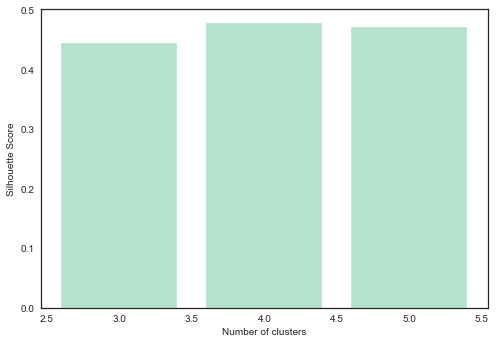

In [18]:
silhouette_scores = [] 
n_clusters = [3, 4, 5]

for n_cluster in n_clusters:
    silhouette_scores.append( 
        silhouette_score(
            rfm_dataframe, 
            KMeans(n_clusters=n_cluster).fit_predict(rfm_dataframe)
        )
    ) 

# Plotting a bar graph to compare the results 
k = [3, 4, 5]
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize=10) 
plt.ylabel('Silhouette Score', fontsize=10) 
plt.show()

Le nombre de cluster idéal avec nos features de RFM est de **4**.

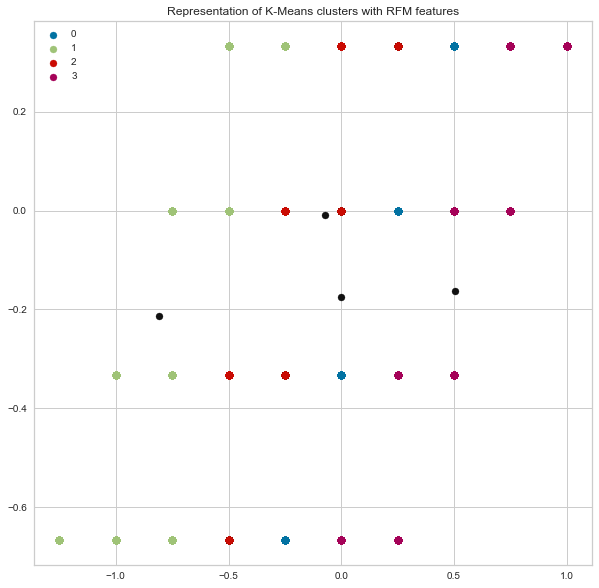

In [6]:
# Create a k-means clustering model
model = KMeans(n_clusters=4, random_state=42)

# Prediction
label = model.fit_predict(rfm_dataframe)
u_labels = np.unique(label)
centroids = model.cluster_centers_

array = rfm_dataframe.to_numpy()

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(array[label==i, 0], array[label==i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:,1], c='k')
plt.legend()
plt.title('Representation of K-Means clusters with RFM features')
plt.show()

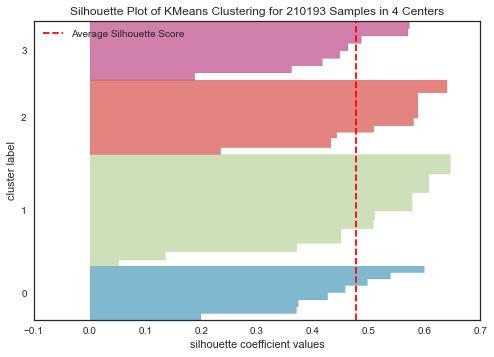

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 210193 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [24]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(rfm_dataframe)
visualizer.show()

In [12]:
# Compute evaluation metric
silhouette = silhouette_score(rfm_dataframe, label)
davies_bouldin = davies_bouldin_score(rfm_dataframe, label)

# Create dataframe for results comparaison
result_dataframe = pd.DataFrame(data={"K-Means" : [silhouette, davies_bouldin]},
                                index=["Silhouette score", "Davies-Bouldin score"])

# Print result
print("Silhouette score:", silhouette)
print("Davies-Bouldin score:", davies_bouldin)

Silhouette score: 0.4775870149911715
Davies-Bouldin score: 0.8731217646065905


C:\Users\raoof\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


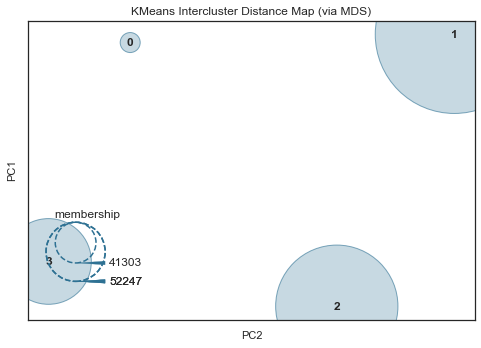

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=4, random_state=42))

In [26]:
intercluster_distance(KMeans(4, random_state=42), rfm_dataframe)

Cette fois-ci, l'attribution du cluster est bon et le score Davies-Bouldin aussi. Nous allons maintenant interpréter nos clusters.

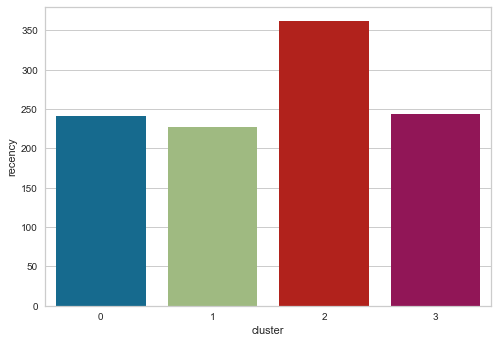

In [56]:
# Import dataframe no normalized
dataframe_no_normalize = pd.read_csv(
    "data/dataframe_no_normalize.csv",
)
dataframe_no_normalize.set_index("customer_unique_id", inplace=True)
dataframe_no_normalize = dataframe_no_normalize.drop(["Unnamed: 0"], axis=1)

# Copy rfm dataframe and merge with no normalized one
rfm_dataframe_copy = rfm_dataframe.copy()
rfm_dataframe_copy['cluster'] = label
rfm_dataframe_copy = pd.merge(rfm_dataframe_copy, dataframe_no_normalize, left_index=True, right_index=True)

# Show the mean recency for each cluster
rfm_dataframe_copy.groupby('cluster', as_index=False)['recency'].mean()

# Plot result
p = sns.barplot(x='cluster', y='recency', data=rfm_dataframe_copy, ci=False)

On voit ici que les clients du cluster 1 sont ceux achetés le plus récemment sur le site de **Olist**. Tandis que ceux du cluster 2 ont effectué leurs derniers achats il y a bien plus longtemps que les autres. Ceux des clusters 0 et 3 ont acheté légèrement moins récemment que le cluster 1.

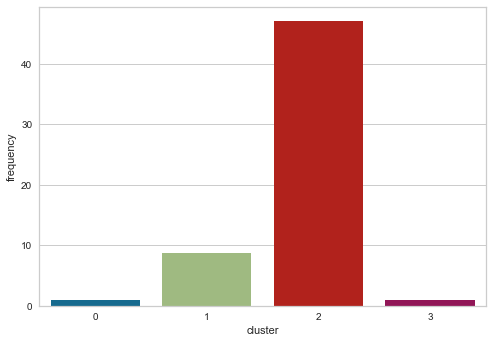

In [52]:
# Show the mean frequency for each cluster
rfm_dataframe_copy.groupby('cluster', as_index=False)['frequency'].mean()

# Plot result
p = sns.barplot(x='cluster', y='frequency', data=rfm_dataframe_copy, ci=False)

Au niveau de la fréquence d'achat, le cluster 2 dépasse les autres largement avec une fréquence plus de 4 fois supérieur. Vient ensuite le cluster 1 qui a tout de même une fréquence assez élevé. Et en dernière position, les clusters 0 et 3 qui ont une fréquence proche de 0.

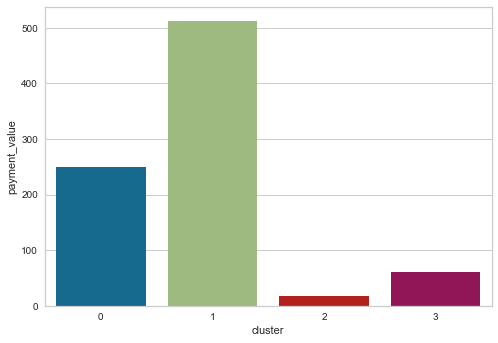

In [57]:
# Show the mean payment value for each cluster
rfm_dataframe_copy.groupby('cluster', as_index=False)['payment_value'].mean()

# Plot result
p = sns.barplot(x='cluster', y='payment_value', data=rfm_dataframe_copy, ci=False)

Enfin, au niveau des montants dépensés, le cluster 1 dépensent plus de 2 fois plus que les autres clusters avec une dépense moyenne de 500 Réal. Le cluster 0 se situe à la seconde position dans ce domaine. Tandis que le cluster 2 est celui qui a la dépense moyenne la plus faible.

Nous pouvons conclure de ces observations que le cluster 1 représente les clients Platinium de la plate-forme, ils dépensent plus et ils viennent souvent. Ce sont les clients à ne perdre. Ensuite les clients du cluster 2 sont le groupe Gold, ils viennent souvent même s'ils ne dépensent pas énormément. Puis vient le cluster 0, le groupe Silver qui dépense assez mais qui ne vient pas très souvent. Et enfin le cluster 3, ils viennent peu souvent et dépensent peu, peut-être juste pour des coupons ou des réductions.

Nous obtenons les meilleurs résultats avec les données RFM. Nous allons donc maintenant observer la stabilité du clustering.

#### d. Stabilité du clustering<a class="anchor" id="IV2d"></a>

Pour évaluer la stabilité de notre clustering, nous allons réappliquer le K-Means mais cette fois sur 50% de notre dataframe.

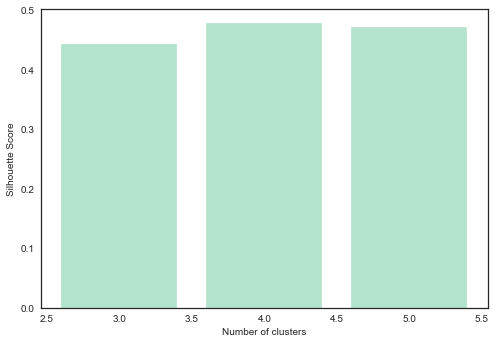

In [27]:
# Keep 50% of dataframe under mean
reduced_rfm_dataframe = rfm_dataframe.sample(frac=0.5, random_state=42)

silhouette_scores = [] 
n_clusters = [3, 4, 5]

for n_cluster in n_clusters:
    silhouette_scores.append( 
        silhouette_score(
            reduced_rfm_dataframe, 
            KMeans(n_clusters=n_cluster).fit_predict(reduced_rfm_dataframe)
        )
    ) 

# Plotting a bar graph to compare the results 
k = [3, 4, 5]
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize=10) 
plt.ylabel('Silhouette Score', fontsize=10) 
plt.show()

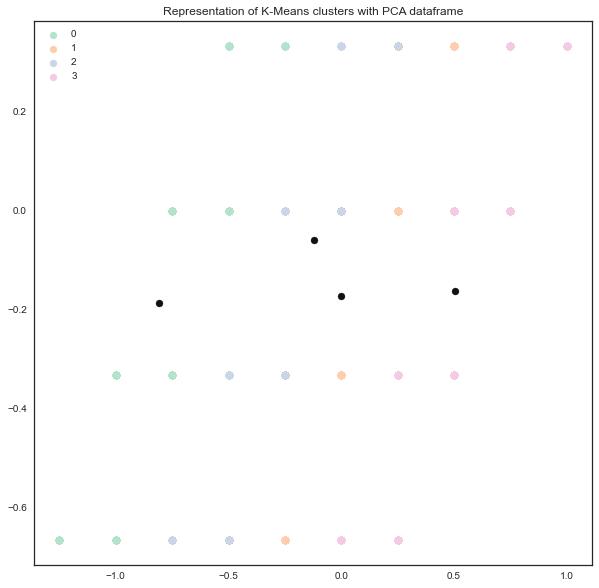

In [28]:
# Fitting KMeans
model = KMeans(n_clusters=4, random_state=42)

# Prediction
label = model.fit_predict(reduced_rfm_dataframe)
u_labels = np.unique(label)
centroids = model.cluster_centers_

array = reduced_rfm_dataframe.to_numpy()

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(array[label==i, 0], array[label==i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:,1], c='k')
plt.legend()
plt.title('Representation of K-Means clusters with PCA dataframe')
plt.show()

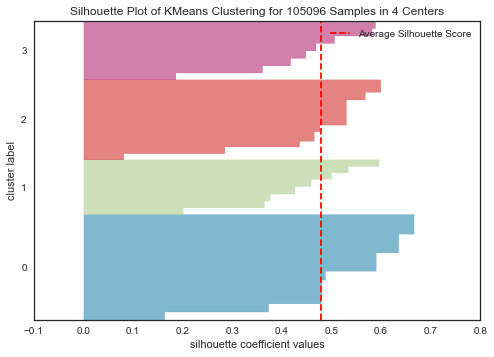

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 105096 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [29]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(reduced_rfm_dataframe)
visualizer.show()

In [30]:
print("Silhouette score:", silhouette_score(reduced_rfm_dataframe, label))
print("Davies-Bouldin score:", davies_bouldin_score(reduced_rfm_dataframe, label))

Silhouette score: 0.4781243675765
Davies-Bouldin score: 0.8721646468681199


C:\Users\raoof\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


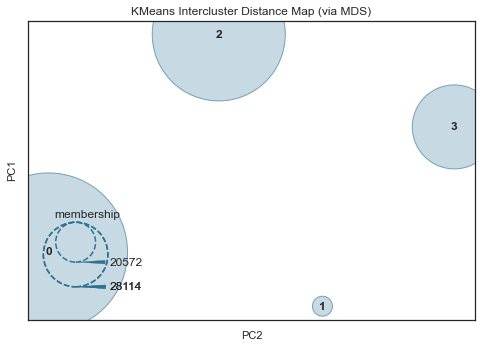

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=4, random_state=42))

In [31]:
intercluster_distance(KMeans(4, random_state=42), reduced_rfm_dataframe)

Nous pouvons voir qu'en utilisant seulement 50% de nos données, nous obtenons des résultats similaires. En effet, nous avons toujours 4 clusters et des scores de Silhouette et Davies-Bouldin proches à 0.001 près. Notre clustering est donc stable. Nous allons tenter une nouvelle proche pour tenter d'encore optimiser nos résultats : **DBSCAN**. 

### 3. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)<a class="anchor" id="IV3"></a>

Le modèle DBSCAN cherche à identifier des groupes de haute densité, puis étendre les clusters de proche en proche à partir de ces noyaux. Ce modèle est souvent très efficace, mais gourmand en mémoire et ne permet pas de choisir le nombre de clusters. Nous devons déterminer le nombre de points requis dans un voisinage pour qu'un point soit considéré comme un point cœur. Etant donné que notre dataframe a plus de 2 dimensions, nous allons prendre un *min_samples* égale à deux fois nos dimensions comme préconisé par Jörg Sander en 1998. Nous aurons donc un *min_samples* à **8**.

À chaque observation, pour compter le nombre de voisins à au plus une distance **ε**, on calcule la distance euclidienne entre le voisin et l’observation et vérifie si c’est inférieur à **ε**. Nous allons choisir un **ε** de tel sorte que 90% des observations aient une distance au proche voisin inférieure à **ε**.

L'algorithme DBSCAN étant difficile à utiliser en très grande dimension (fléau de la dimensionalité), nous allons l'utiliser uniquement sur nos features RFM (au nombre de 4) et non sur l'ensemble de nos données ou de nos données réduites.

(200000.0, 220000.0, 0.0, 0.3)

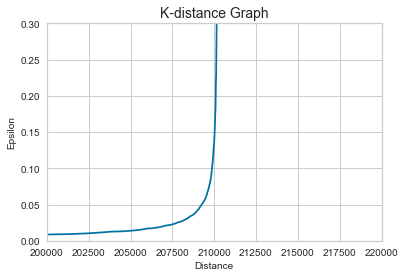

In [15]:
%matplotlib inline

neighbors = NearestNeighbors(n_neighbors=8)
neighbors_fit = neighbors.fit(rfm_dataframe)
distances, indices = neighbors_fit.kneighbors(rfm_dataframe)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title('K-distance Graph',fontsize=14)
plt.xlabel('Distance', fontsize=10) 
plt.ylabel('Epsilon', fontsize=10)
plt.axis([200000, 220000, 0, 0.3])

Ici, le NearestNeighbors nous donne un **ε** à 0.06. 

In [18]:
optimized_dbscan = DBSCAN(eps=0.06, min_samples=8).fit(rfm_dataframe)
prediction = DBSCAN(eps=0.06, min_samples=8).fit_predict(rfm_dataframe)
optimized_cluster = optimized_dbscan.labels_

# Compute evaluation metric
silhouette = silhouette_score(rfm_dataframe, prediction)
davies_bouldin = davies_bouldin_score(rfm_dataframe, prediction)

print("Number of clusters:", len(set(optimized_cluster)))
print("Silhouette score:", silhouette)
print("Davies-Bouldin score:", davies_bouldin)

Number of clusters: 2077
Silhouette score: 0.35958118986889176
Davies-Bouldin score: 0.7060865700280508


Nous trouvons un nombre de clusters bien trop élevé pour que ce soit exploitable, nous allons donc essayer avec un **ε** à 0,7.

In [22]:
optimized_dbscan = DBSCAN(eps=0.7, min_samples=8).fit(rrr)
prediction = DBSCAN(eps=0.7, min_samples=8).fit_predict(rrr)
optimized_cluster = optimized_dbscan.labels_

# Compute evaluation metric
silhouette = silhouette_score(rrr, prediction)
davies_bouldin = davies_bouldin_score(rrr, prediction)

# Add result in results dataframe
result_dataframe["DBSCAN"] = [silhouette, davies_bouldin]

print("Number of clusters:", len(set(optimized_cluster)))
print("Silhouette score:", silhouette)
print("Davies-Bouldin score:", davies_bouldin)

Number of clusters: 150
Silhouette score: 0.28475773812459215
Davies-Bouldin score: 0.5817437134610209


Le DBSCAN nous a trouvé 150 clusters, ce qui reste bien trop élevé pour être exploitable par l'équipe marketing de **Olist**. Nous allons donc essayer une nouvelle approche : le **clustering hiérarchique**.

### 4. Clustering agglomératif<a class="anchor" id="IV4"></a>

On commence par considérer que chaque point est un cluster à lui tout seul. Ensuite, on trouve les deux clusters les plus proches, et on les agglomère en un seul cluster. On répète cette étape jusqu'à ce que tous les points appartiennent à un seul cluster, constitué de l'agglomération de tous les clusters initiaux. 

Cette méthode a l'avantage qu'il n'est pas nécessaire de définir le nombre de clusters à l'avance vu qu'on explore toutes les possibilités. Cependant, cela ne fait que repousser cette décision. Pour prendre cette décision, nous allons nous baser sur un dendrogramme.

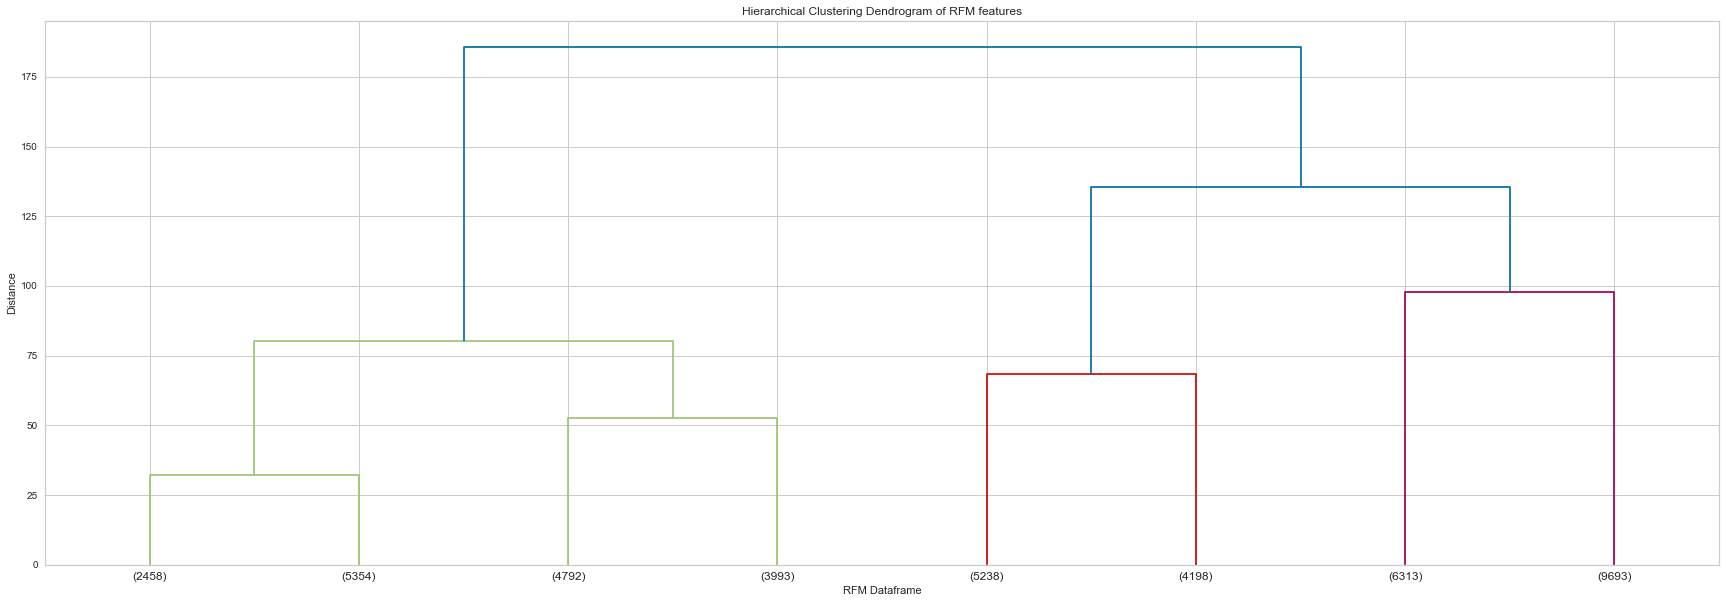

In [5]:
# Generate the linkage matrix
linkage_data = linkage(rfm_dataframe.sample(frac=0.2, random_state=42), method="ward")

# Plot the hierarchical clustering of the RFM features
plt.figure(figsize=(30, 10))
plt.title('Hierarchical Clustering Dendrogram of RFM features')
plt.xlabel('RFM Dataframe')
plt.ylabel('Distance')
dendrogram(
    linkage_data,
    truncate_mode="level",
    p=2,
)
plt.show()

Pour calculer la distance entre nos clusters, nous avons utilisé le clustering de Ward afin de minimiser l'augmentation de la variance inter-cluster due à l'agrégation de clusters effectuée.

Nous voyons qu'avec 2 clusters, nous sommes dans la zone la plus large entre deux nouveaux clusters. Une segmentation à 4 ou 6 clusters seraient aussi possibles.

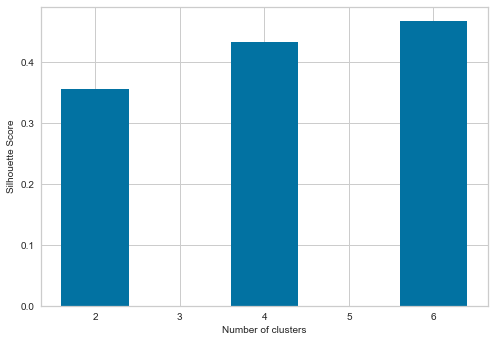

In [6]:
silhouette_scores = [] 
n_clusters = [2, 4, 6]

for n_cluster in n_clusters:
    silhouette_scores.append( 
        silhouette_score(
            rfm_dataframe.sample(frac=0.2, random_state=42), 
            AgglomerativeClustering(n_clusters=n_cluster).fit_predict(rfm_dataframe.sample(frac=0.2, random_state=42))
        )
    ) 

# Plotting a bar graph to compare the results 
k = [2, 4, 6] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize=10) 
plt.ylabel('Silhouette Score', fontsize=10) 
plt.show() 

On remarque ici que nous obtenons le meilleur score de Silhouette avec 6 clusters. Cependant c'est un nombre trop élevé de clusters pour effectuer une segmentation efficace. Nous allons donc garder 4 clusters.

In [13]:
# Fitting AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=4)

# Prediction
prediction = model.fit_predict(rfm_dataframe.sample(frac=0.2, random_state=42))

# Compute evaluation metric
silhouette = silhouette_score(rfm_dataframe.sample(frac=0.2, random_state=42), prediction)
davies_bouldin = davies_bouldin_score(rfm_dataframe.sample(frac=0.2, random_state=42), prediction)

# Add result in results dataframe
result_dataframe["Agglomerative Clustering"] = [silhouette, davies_bouldin]

print("Silhouette score:", silhouette)
print("Davies-Bouldin score:", davies_bouldin)

Silhouette score: 0.4317029295881506
Davies-Bouldin score: 0.8820255825435541


In [23]:
result_dataframe

,K-Means,Agglomerative Clustering,DBSCAN
Silhouette score,0.477587,0.431703,0.284758
Davies-Bouldin score,0.873122,0.882026,0.581744


Nous avons obtenu de bons scores néanmoins ils restent légèrement moins bons que ceux obtenus avec le K-means pour un temps d'exécution plus long.

### 5. Maintenance de la solution<a class="anchor" id="IV5"></a>

Le K-means avec les données RFM est donc la solution avec la meilleure segmentation et le temps d'exécution le plus court. Nous allons maintenant nous intéresser à la maintenance de la solution. Pour réaliser celle-ci, nous allons nous baser sur l'indice de Rand compris entre 0 et 1, 1 représentant une similarité exact. Ce dernier calcule une mesure de similarité entre deux clusters en considérant toutes les paires d'échantillons et en comptant les paires qui sont attribuées dans les mêmes clusters ou dans des clusters différents dans les données prédites et vraies.

In [19]:
# Create a copy of rfm dataframe
dataframe_2016 = dataframe[
    dataframe['order_purchase_timestamp_year'] == 2016
]
dataframe_2017_6 = dataframe[
    (dataframe['order_purchase_timestamp_year'] == 2017) & (dataframe['order_purchase_timestamp_month'] <= 6)
]
dataframe_2017_6 = dataframe_2017_6.append(dataframe_2016)
stability = pd.DataFrame({'label_begin': label[0:43830]})

cpt = 1
for i in range(7, 13):
    # Add month changes
    dataframe_ = dataframe[
        (dataframe['order_purchase_timestamp_year'] == 2017) & 
        (dataframe['order_purchase_timestamp_month'] > 6) & 
        (dataframe['order_purchase_timestamp_month'] <= i)
    ]
    dataframe_ = dataframe_.append(dataframe_2017_6)
    maintenance_rfm_dataframe = dataframe_[['RFM_score', 'R', 'F', 'M']].copy()
    label_change = model.predict(maintenance_rfm_dataframe)
    stability["label_" + str(cpt) + "m"] = label_change[0:43830]
    cpt += 1
    
stability.describe()

,label_begin,label_1m,label_2m,label_3m,label_4m,label_5m,label_6m
count,43830.000000,43830.000000,43830.000000,43830.000000,43830.000000,43830.000000,43830.000000
mean,1.444969,1.551221,1.593269,1.577207,1.550399,1.542277,1.518891
std,1.018535,0.957379,0.929859,0.930301,0.928557,0.928373,0.952736
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [21]:
dataframe_2016_2017 = dataframe[
    (dataframe['order_purchase_timestamp_year'] == 2016) | (dataframe['order_purchase_timestamp_year'] == 2017)
]
cpt = 7
for i in range(1, 7):
    # Add month changes
    dataframe_ = dataframe[
        (dataframe['order_purchase_timestamp_year'] == 2018) & 
        (dataframe['order_purchase_timestamp_month'] <= i)
    ]
    dataframe_ = dataframe_.append(dataframe_2016_2017)
    maintenance_rfm_dataframe = dataframe_[['RFM_score', 'R', 'F', 'M']].copy()
    label_change = model.predict(maintenance_rfm_dataframe)
    stability["label_" + str(cpt) + "m"] = label_change[0:43830]
    cpt += 1
    
stability.describe()

,label_begin,label_1m,label_2m,label_3m,label_4m,label_5m,label_6m,label_7m,label_8m,label_9m,label_10m,label_11m,label_12m
count,43830.000000,43830.000000,43830.000000,43830.000000,43830.000000,43830.000000,43830.000000,43830.000000,43830.00000,43830.000000,43830.000000,43830.000000,43830.000000
mean,1.444969,1.551221,1.593269,1.577207,1.550399,1.542277,1.518891,1.456833,1.46078,1.437988,1.433653,1.431371,1.417363
std,1.018535,0.957379,0.929859,0.930301,0.928557,0.928373,0.952736,1.003881,1.00311,1.019880,1.021887,1.026104,1.020542
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000


In [33]:
for i in range(1, 13):
    if i == 1:
        rand = pd.DataFrame(
            {"Rand score": [rand_score(stability['label_begin'], 
                                       stability["label_" + str(i) +"m"])]}, index=[str(i) + ' mois']
        )
    else:
        row = pd.Series({"Rand score": 
                         rand_score(stability['label_begin'], stability["label_" + str(i) +"m"])}, name=str(i) + ' mois')
        rand = rand.append(row)

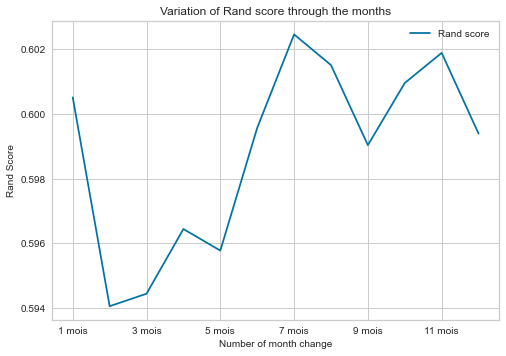

In [37]:
rand.plot(legend=True)
plt.title('Variation of Rand score through the months')
plt.xlabel('Number of month change', fontsize=10) 
plt.ylabel('Rand Score', fontsize=10) 
plt.show()

On voit que la qualité du clustering de notre modèle se dégrade très vite. Une maintenance bimensuelle sera nécessaire pour pouvoir obtenir une segmentation qui ait encore du sens.